In [1]:
!pip install geopandas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Set the style of the seaborn plots
sns.set_style("whitegrid")  # Set a background grid for a clean look

# Set the color palette for the seaborn plots
sns.set_palette("husl")  # Colorblind-friendly palette

# Set the context for plotting 
sns.set_context("notebook", font_scale=1.2)  # Adjust font scale for notebook context

# Set Matplotlib defaults
plt.rcParams['figure.figsize'] = [10, 6]  # Default figure size for plots
plt.rcParams['figure.titlesize'] = 'large'  # Default title size
plt.rcParams['axes.titlesize'] = 'medium'  # Default axes title size
plt.rcParams['axes.labelsize'] = 'medium'  # Default label size for x and y axes
plt.rcParams['xtick.labelsize'] = 'small'  # Default x-tick label size
plt.rcParams['ytick.labelsize'] = 'small'  # Default y-tick label size
plt.rcParams['legend.fontsize'] = 'medium'  # Default legend font size
plt.rcParams['axes.grid'] = True  # Enable grid by default


In [4]:
# Load the dataset
data = pd.read_csv('data2.csv',index_col=0)  # Replace with your file path
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,Region,Income Level
0,Aruba,ABW,Forest area (% of land area),AG.LND.FRST.ZS,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,...,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,Latin America & Caribbean,High Income
1,Africa Eastern and Southern,AFE,Forest area (% of land area),AG.LND.FRST.ZS,34.717473,34.537463,34.357452,34.177441,33.654274,33.475977,...,31.470634,31.260420,31.039682,30.824316,30.611512,30.391626,30.174253,29.955194,Aggregates,Lower-Middle Income
2,Afghanistan,AFG,Forest area (% of land area),AG.LND.FRST.ZS,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,...,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,South Asia,Low Income
3,Africa Western and Central,AFW,Forest area (% of land area),AG.LND.FRST.ZS,21.595284,21.503156,21.411029,21.318902,21.226775,21.134648,...,20.322187,20.234231,20.152610,20.071327,19.986100,19.901215,19.816777,19.732037,Aggregates,Lower-Middle Income
4,Angola,AGO,Forest area (% of land area),AG.LND.FRST.ZS,62.331443,61.886219,61.440995,60.995770,60.550546,60.105322,...,56.098301,55.653076,55.207845,54.762629,54.317406,53.872175,53.426951,52.981722,Sub-Saharan Africa,Lower-Middle Income


In [5]:
data['Indicator Name'].unique()

array(['Forest area (% of land area)',
       'Electric power consumption (kWh per capita)',
       'CO2 emissions (kg per PPP $ of GDP)',
       'GDP per capita (current US$)',
       'GNI per capita, Atlas method (current US$)'], dtype=object)

In [6]:
numerical_columns = data.select_dtypes(include=['number']).columns

# Fill null values with the minimum value for each numerical column if min >= 0, otherwise fill with 0
data_filled = data.copy()
for col in numerical_columns:
    if data[col].min() >= 0:
        data_filled[col].fillna(data[col].min(), inplace=True)
    else:
        data_filled[col].fillna(0, inplace=True)

# Display the DataFrame with filled values
data=data_filled.copy()

In [7]:
electricity_data = data[data['Indicator Name'] == 'Electric power consumption (kWh per capita)']
co2_data = data[data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']
forest_data = data[data['Indicator Name'] == 'Forest area (% of land area)']
gdp_data = data[data['Indicator Name'] == 'GDP per capita (current US$)']

In [8]:
# Filtering the data for the year 2014
data_2014 = data[['Country Name', 'Indicator Name', '2014']]

# Pivoting the data to have indicators as columns
data_2014_pivoted = data_2014.pivot(index='Country Name', columns='Indicator Name', values='2014').reset_index()

# Renaming the columns based on the indicators
data_2014_pivoted.columns.name = None
data_2014_pivoted.rename(columns={
    'CO2 emissions (kg per PPP $ of GDP)': 'CO2 Emissions',
    'Electric power consumption (kWh per capita)': 'Electricity Consumption',
    'Forest area (% of land area)': 'Forest Area',
    'GDP per capita (current US$)': 'GDP Per Capita'
}, inplace=True)

# Displaying the reformatted data for 2014
data_2014_pivoted.head()

,Country Name,CO2 Emissions,Electricity Consumption,Forest Area,GDP Per Capita,"GNI per capita, Atlas method (current US$)"
0,Afghanistan,0.134399,3905.447458,1.852782,628.146804,650.000000
1,Africa Eastern and Southern,0.292009,680.149943,31.470634,1724.534381,1696.462899
2,Africa Western and Central,0.119082,183.440206,20.322187,2247.857492,2101.336153
3,Albania,0.159487,2309.366503,28.750511,4578.633208,4540.000000
4,Algeria,0.291889,1368.621519,0.818057,5516.229463,5510.000000


# Impact of Economic Development on Emissions

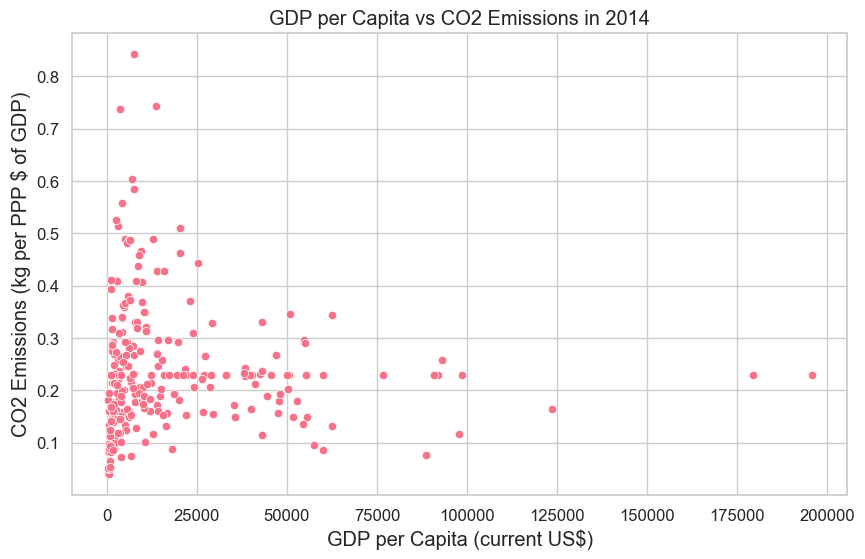

In [9]:
year='2014'

# Correlation and Plotting for GDP per Capita vs CO2 Emissions
merged_gdp_co2 = pd.merge(gdp_data[['Country Name', year]], co2_data[['Country Name', year]], on='Country Name', suffixes=('_gdp', '_co2')).dropna()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=year + '_gdp', y=year + '_co2', data=merged_gdp_co2)
plt.title('GDP per Capita vs CO2 Emissions in 2014')
plt.xlabel('GDP per Capita (current US$)')
plt.ylabel('CO2 Emissions (kg per PPP $ of GDP)')
plt.grid(True)
plt.show()

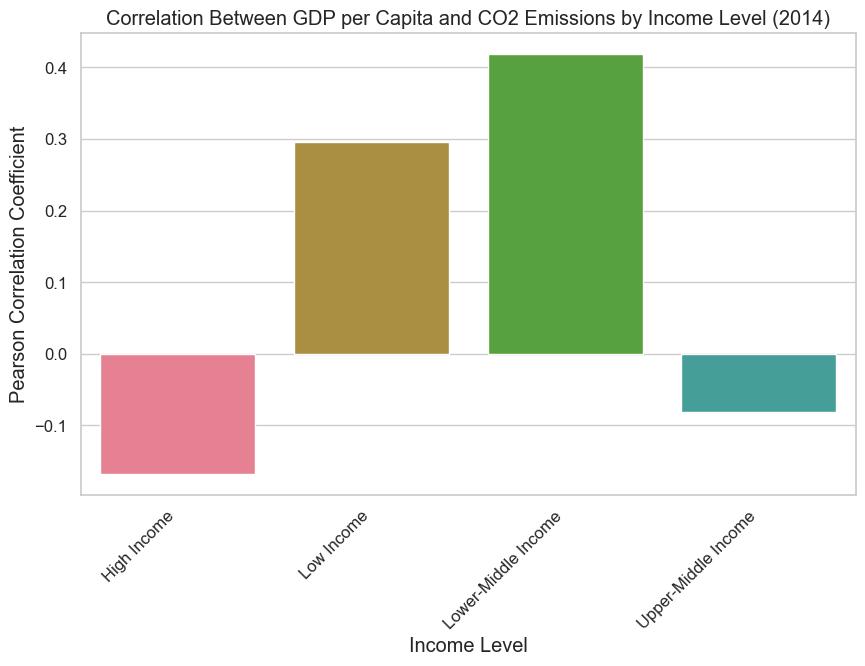

In [10]:
# Filter data for the year 2014
data_2014 = data[['Income Level', 'Indicator Name', '2014']]

# Group data by 'Income Level' and calculate correlation for each income level
income_correlations = {}
for income, income_data in data_2014.groupby('Income Level'):
    # Selecting relevant columns for the correlation calculation
    gdp_income = income_data[income_data['Indicator Name'] == 'GDP per capita (current US$)']['2014']
    co2_income = income_data[income_data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']['2014']

    # Drop NaN values
    gdp_income = gdp_income.dropna()
    co2_income = co2_income.dropna()

    # Calculate the Pearson correlation for each income level
    corr, _ = pearsonr(gdp_income, co2_income)
    income_correlations[income] = corr

# Convert the results to a DataFrame for plotting
income_correlation_df = pd.DataFrame(list(income_correlations.items()), columns=['Income Level', 'Correlation'])

# Plotting the correlation for each income level
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Level', y='Correlation', data=income_correlation_df)
plt.title('Correlation Between GDP per Capita and CO2 Emissions by Income Level (2014)')
plt.xlabel('Income Level')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

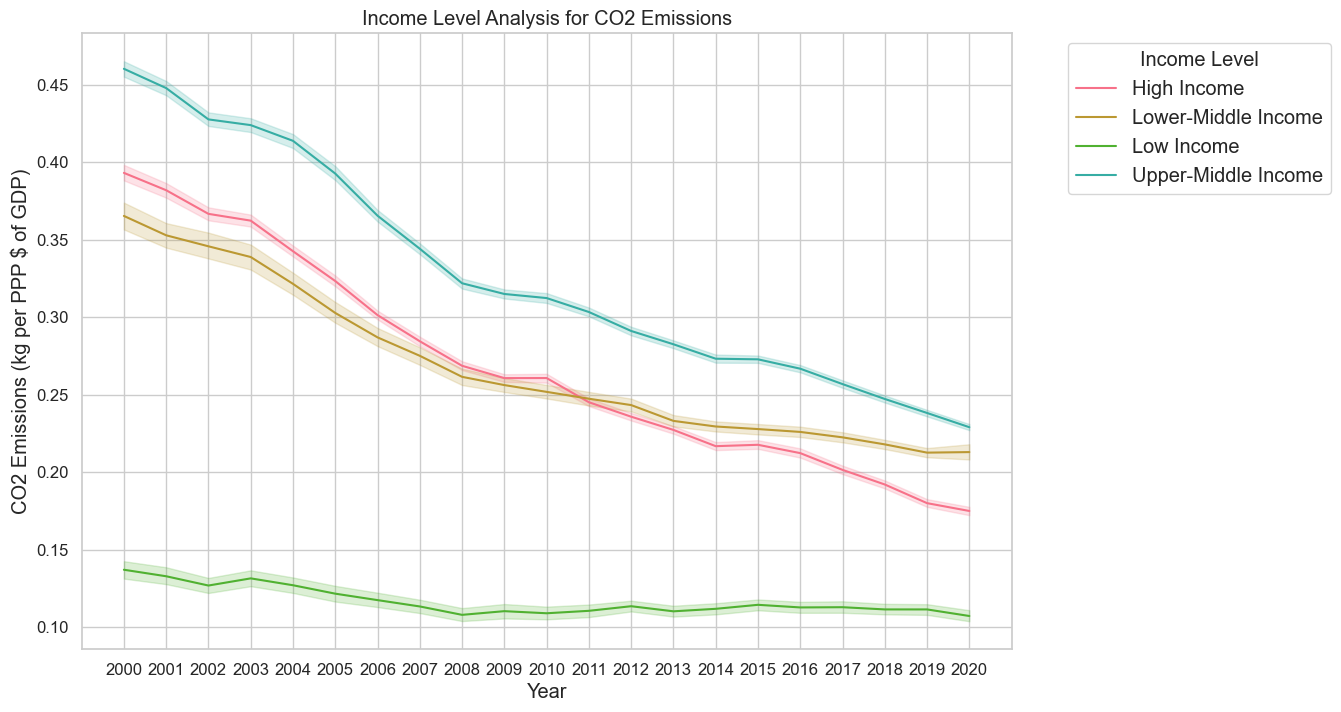

In [11]:
co2_data = data[data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']
co2_data = co2_data.set_index('Income Level')

# Transpose the DataFrame for easier plotting
co2_data_t = co2_data.iloc[:, 4:-2].transpose()

# Plotting the income level trends for CO2 emissions
plt.figure(figsize=(12, 8))
sns.lineplot(data=co2_data_t, dashes=False)
plt.title('Income Level Analysis for CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kg per PPP $ of GDP)')
plt.legend(title='Income Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Climate Change and Electric power consumption

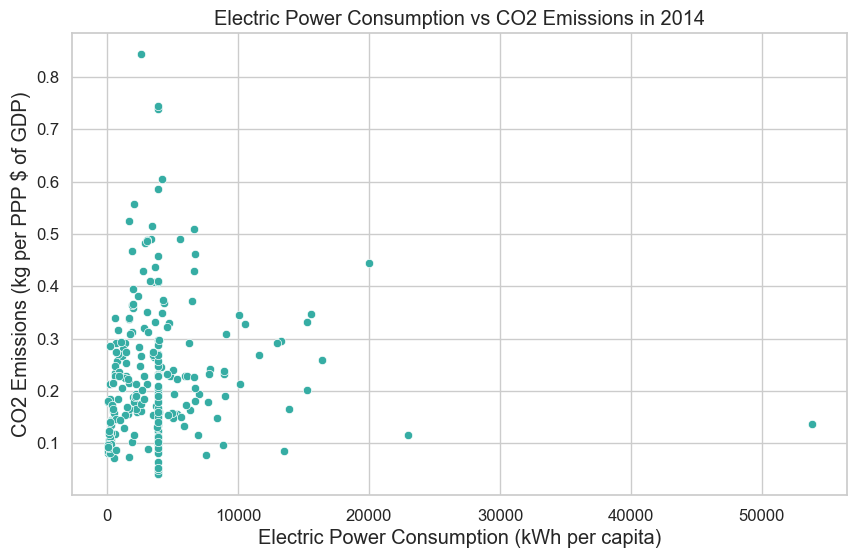

In [12]:
# Correlation and Plotting for Electricity Consumption vs CO2 Emissions
merged_electricity_co2 = pd.merge(electricity_data[['Country Name', year]], co2_data[['Country Name', year]], on='Country Name', suffixes=('_electricity', '_co2')).dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=year + '_electricity', y=year + '_co2', data=merged_electricity_co2, color=sns.color_palette("husl", n_colors=2)[1])
plt.title(f'Electric Power Consumption vs CO2 Emissions in {year}')
plt.xlabel('Electric Power Consumption (kWh per capita)')
plt.ylabel('CO2 Emissions (kg per PPP $ of GDP)')
plt.grid(True)
plt.show()

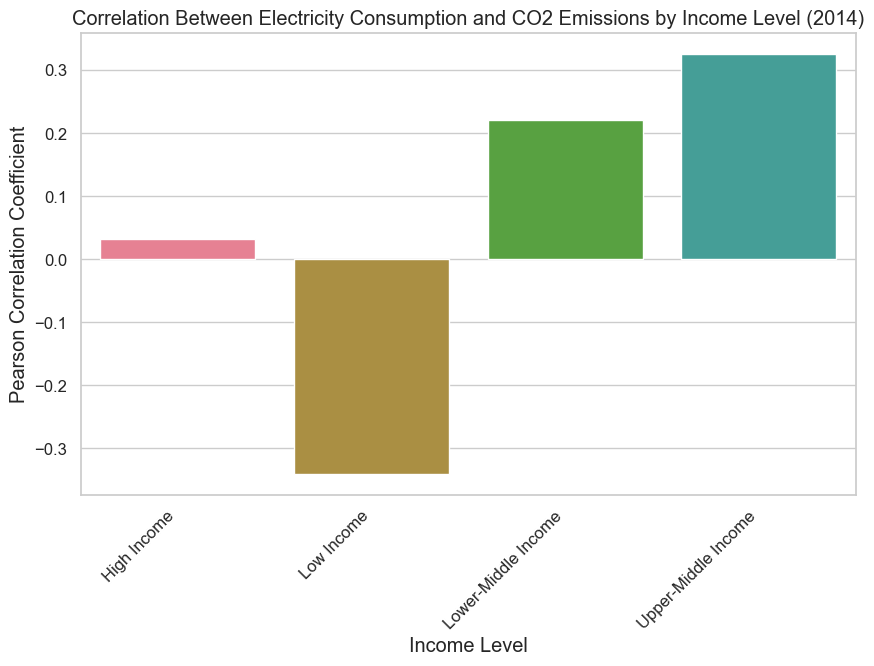

In [13]:
# Filter data for the year 2014
data_2014 = data[['Income Level', 'Indicator Name', '2014']]

# Group data by 'Income Level' and calculate correlation for each income level
income_correlations = {}
for income, income_data in data_2014.groupby('Income Level'):
    # Selecting relevant columns for the correlation calculation
    electricity_income = income_data[income_data['Indicator Name'] == 'Electric power consumption (kWh per capita)']['2014']
    co2_income = income_data[income_data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']['2014']

    # Drop NaN values
    electricity_income = electricity_income.dropna()
    co2_income = co2_income.dropna()

    # Calculate the Pearson correlation for each income level
    corr, _ = pearsonr(electricity_income, co2_income)
    income_correlations[income] = corr

# Convert the results to a DataFrame for plotting
income_correlation_df = pd.DataFrame(list(income_correlations.items()), columns=['Income Level', 'Correlation'])

# Plotting the correlation for each income level
plt.figure(figsize=(10, 6))
sns.barplot(x='Income Level', y='Correlation', data=income_correlation_df)
plt.title('Correlation Between Electricity Consumption and CO2 Emissions by Income Level (2014)')
plt.xlabel('Income Level')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

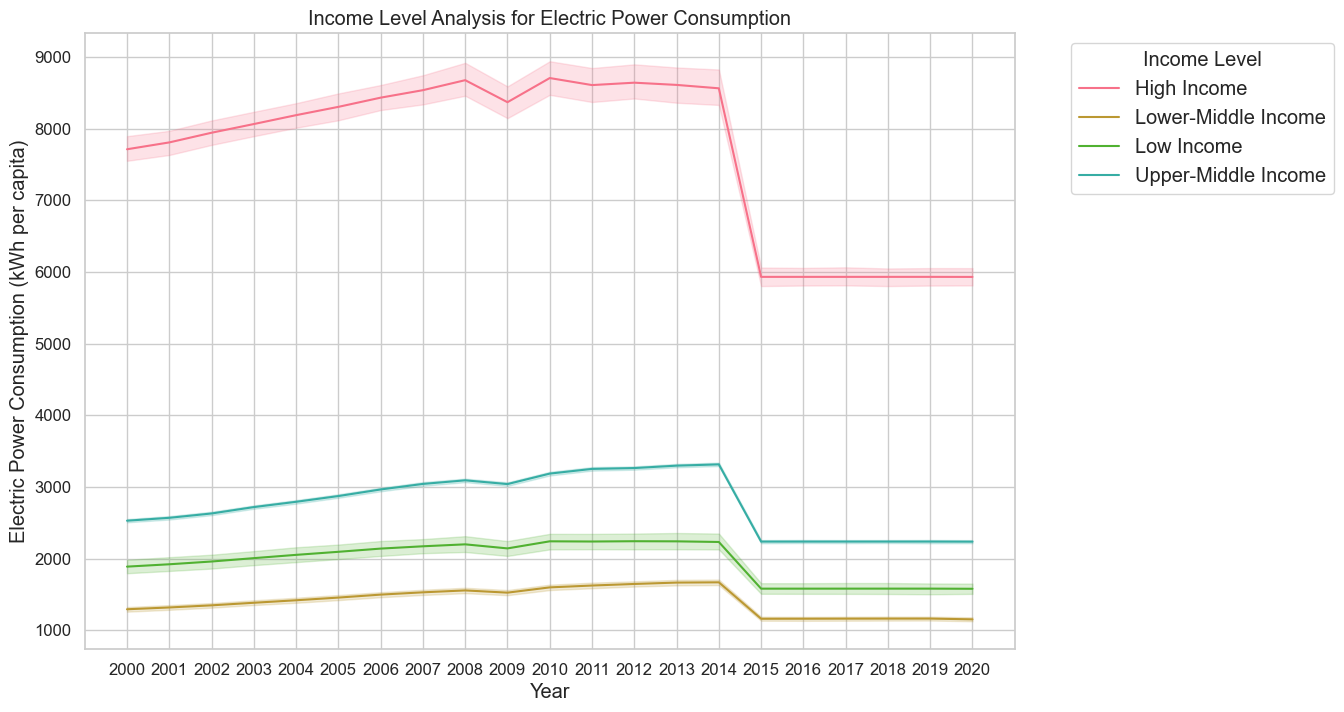

In [14]:
electric_power_data = data[data['Indicator Name'] == 'Electric power consumption (kWh per capita)']
electric_power_data = electric_power_data.set_index('Income Level')

# Transpose the DataFrame for easier plotting
electric_power_data_t = electric_power_data.iloc[:, 4:-2].transpose()

# Plotting the income level trends for electric power consumption
plt.figure(figsize=(12, 8))
sns.lineplot(data=electric_power_data_t, dashes=False)
plt.title('Income Level Analysis for Electric Power Consumption')
plt.xlabel('Year')
plt.ylabel('Electric Power Consumption (kWh per capita)')
plt.legend(title='Income Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Deforestation and Climate Change

C:\Users\mryou\AppData\Local\Temp\ipykernel_14536\3548191564.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


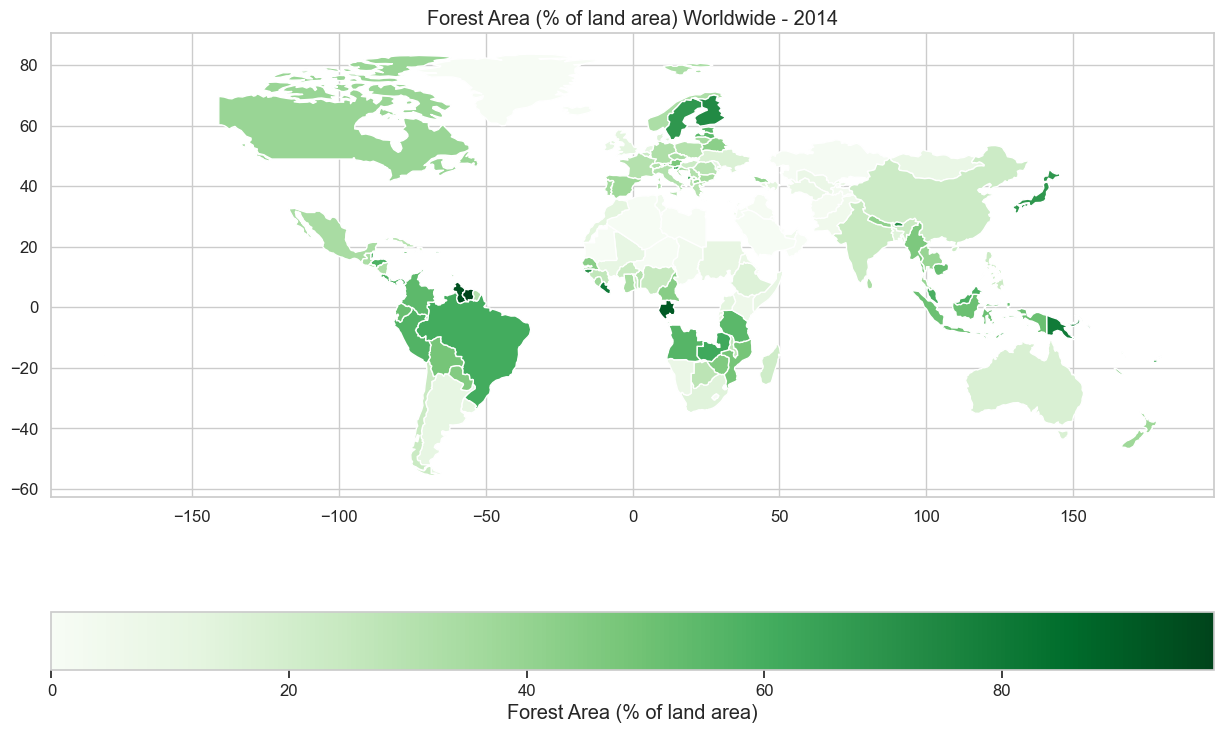

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Loading the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merging the world map with the 2014 forest area data
world_forest = world.merge(data_2014_pivoted[['Country Name', 'Forest Area']], left_on='name', right_on='Country Name')

# Plotting the heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_forest.plot(column='Forest Area', ax=ax, legend=True, 
                  legend_kwds={'label': "Forest Area (% of land area)", 'orientation': "horizontal"},
                  cmap='Greens')
plt.title('Forest Area (% of land area) Worldwide - 2014')
plt.show()

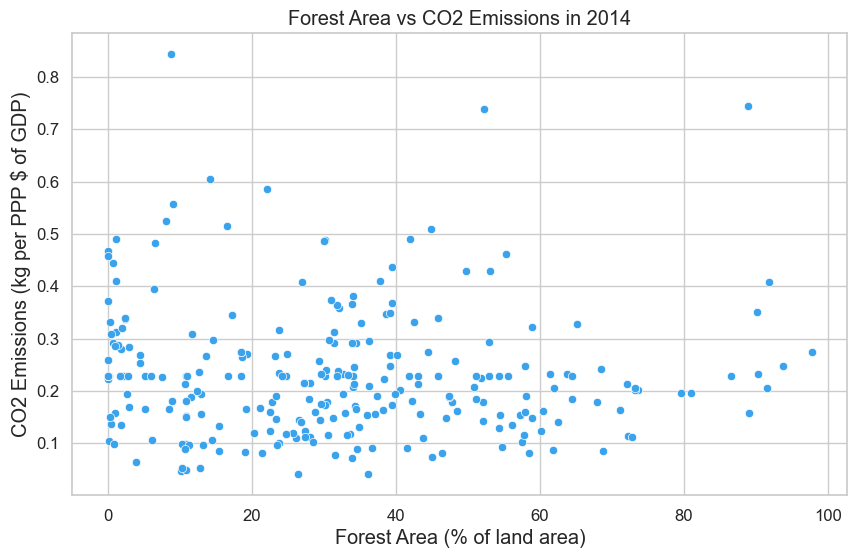

In [16]:
# Correlation and Plotting for Forest Area vs CO2 Emissions
merged_forest_co2 = pd.merge(forest_data[['Country Name', year]], co2_data[['Country Name', year]], on='Country Name', suffixes=('_forest', '_co2')).dropna()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=year + '_forest', y=year + '_co2', data=merged_forest_co2, color=sns.color_palette("husl", n_colors=3)[2])
plt.title('Forest Area vs CO2 Emissions in 2014')
plt.xlabel('Forest Area (% of land area)')
plt.ylabel('CO2 Emissions (kg per PPP $ of GDP)')
plt.grid(True)
plt.show()

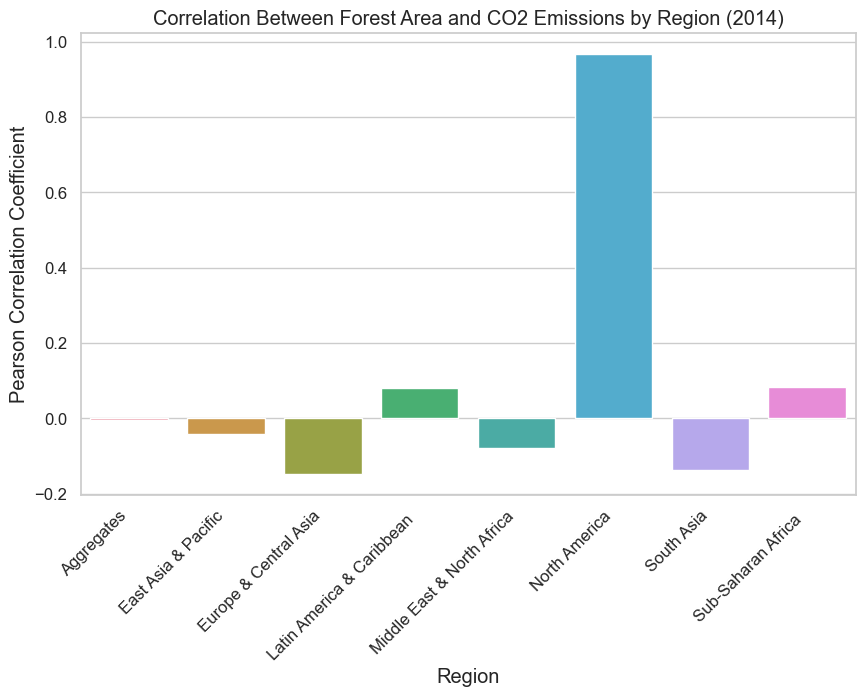

In [17]:
# Filter data for the year 2014
data_2014 = data[['Country Code', 'Region','Indicator Name', '2014']]

# Group data by 'Region' and calculate correlation for each region
region_correlations = {}
for region, region_data in data_2014.groupby('Region'):
    # Selecting relevant columns for the correlation calculation
    forest_region = region_data[region_data['Indicator Name'] == 'Forest area (% of land area)']['2014']
    co2_region = region_data[region_data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']['2014']

    # Drop NaN values
    forest_region = forest_region.dropna()
    co2_region = co2_region.dropna()

    # Calculate the Pearson correlation for each region
    corr, _ = pearsonr(forest_region, co2_region)
    region_correlations[region] = corr

# Convert the results to a DataFrame for plotting
region_correlation_df = pd.DataFrame(list(region_correlations.items()), columns=['Region', 'Correlation'])

# Plotting the correlation for each region
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Correlation', data=region_correlation_df)
plt.title('Correlation Between Forest Area and CO2 Emissions by Region (2014)')
plt.xlabel('Region')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

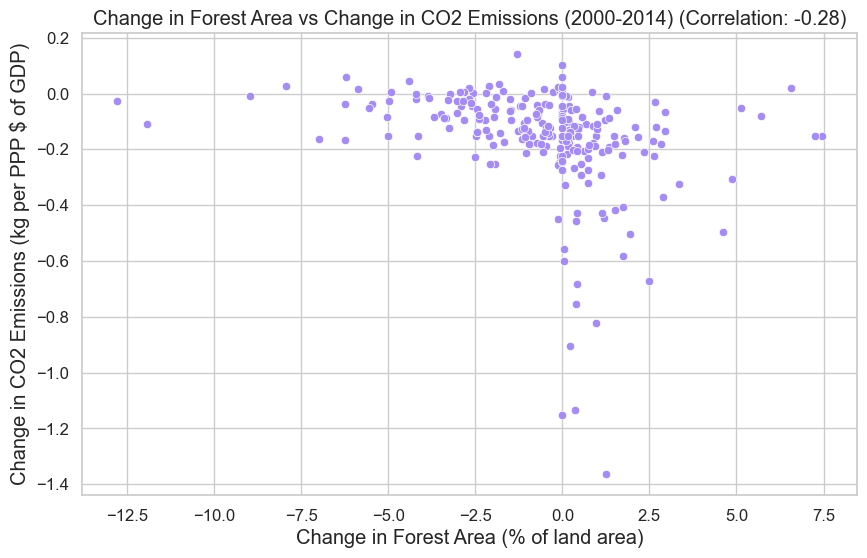

In [18]:

# Selecting relevant columns for the years 2000 and 2014
data_2000 = data[['Country Name', 'Indicator Name', '2000']]
data_2000_pivoted = data_2000.pivot(index='Country Name', columns='Indicator Name', values='2000').reset_index()
data_2000_pivoted.rename(columns={
    'CO2 emissions (kg per PPP $ of GDP)': 'CO2 Emissions 2000',
    'Forest area (% of land area)': 'Forest Area 2000'
}, inplace=True)

# Merging the 2000 and 2014 data
change_data = pd.merge(data_2000_pivoted[['Country Name', 'Forest Area 2000', 'CO2 Emissions 2000']], 
                       data_2014_pivoted[['Country Name', 'Forest Area', 'CO2 Emissions']], 
                       on='Country Name')

# Calculating the change in forest area and CO2 emissions
change_data['Forest Area Change'] = change_data['Forest Area'] - change_data['Forest Area 2000']
change_data['CO2 Emissions Change'] = change_data['CO2 Emissions'] - change_data['CO2 Emissions 2000']

# Dropping NaN values for accurate correlation calculation
change_data.dropna(subset=['Forest Area Change', 'CO2 Emissions Change'], inplace=True)

# Calculating the Pearson correlation for the change data
corr_change, _ = pearsonr(change_data['Forest Area Change'], change_data['CO2 Emissions Change'])

# Plotting the relationship of changes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Forest Area Change', y='CO2 Emissions Change', data=change_data, color=sns.color_palette("husl", n_colors=4)[3])
plt.title(f'Change in Forest Area vs Change in CO2 Emissions (2000-2014) (Correlation: {corr_change:.2f})')
plt.xlabel('Change in Forest Area (% of land area)')
plt.ylabel('Change in CO2 Emissions (kg per PPP $ of GDP)')
plt.show()

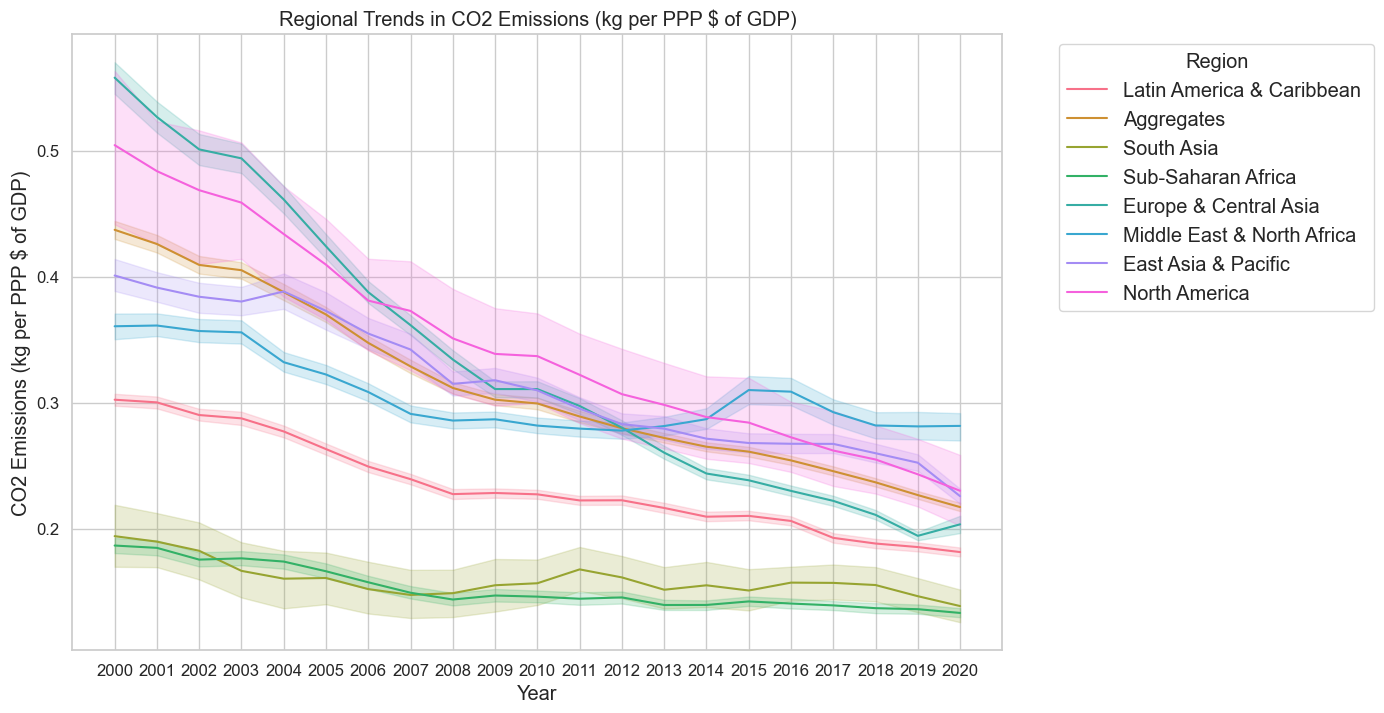

In [19]:
co2_data = data[data['Indicator Name'] == 'CO2 emissions (kg per PPP $ of GDP)']
co2_data = co2_data.set_index('Region')

# Transpose the DataFrame for easier plotting
co2_data_t = co2_data.iloc[:, 4:-2].transpose()

# Plotting the regional trends for CO2 emissions
plt.figure(figsize=(12, 8))
sns.lineplot(data=co2_data_t, dashes=False)
plt.title('Regional Trends in CO2 Emissions (kg per PPP $ of GDP)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (kg per PPP $ of GDP)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Cluster Analysis

C:\Users\mryou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mryou\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


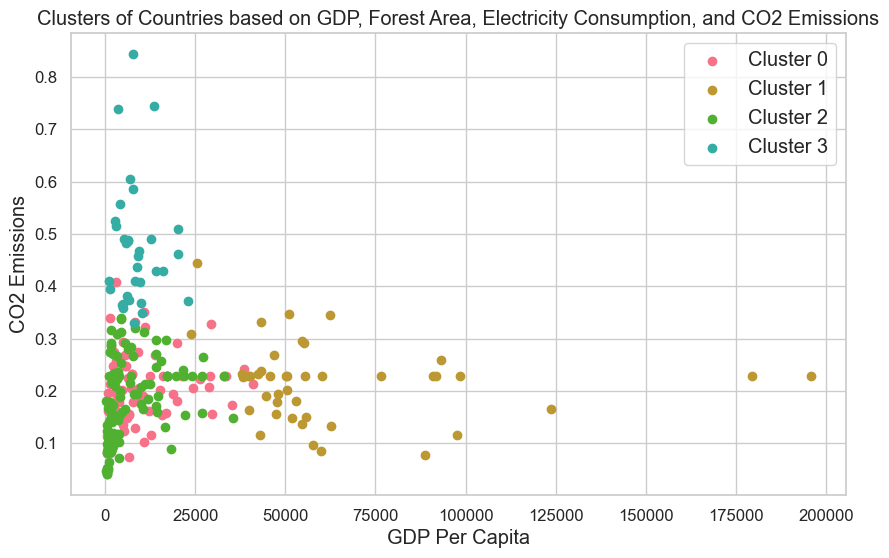

,Country Name,CO2 Emissions,Electricity Consumption,Forest Area,GDP Per Capita,"GNI per capita, Atlas method (current US$)",Cluster
0,Afghanistan,0.134399,3905.447458,1.852782,628.146804,650.000000,2
1,Africa Eastern and Southern,0.292009,680.149943,31.470634,1724.534381,1696.462899,2
2,Africa Western and Central,0.119082,183.440206,20.322187,2247.857492,2101.336153,2
3,Albania,0.159487,2309.366503,28.750511,4578.633208,4540.000000,2
4,Algeria,0.291889,1368.621519,0.818057,5516.229463,5510.000000,2


In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Conducting a Cluster Analysis
# Preparing the data for clustering (using the 2014 data as an example)
cluster_data = data_2014_pivoted.dropna(subset=['GDP Per Capita', 'Forest Area', 'Electricity Consumption', 'CO2 Emissions'])
X_cluster = cluster_data[['GDP Per Capita', 'Forest Area', 'Electricity Consumption', 'CO2 Emissions']]

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Applying K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Adding cluster labels to the data
cluster_data['Cluster'] = labels

# Plotting the clusters
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.scatter(cluster_data[cluster_data['Cluster'] == i]['GDP Per Capita'], 
                cluster_data[cluster_data['Cluster'] == i]['CO2 Emissions'], 
                label=f'Cluster {i}')

plt.title('Clusters of Countries based on GDP, Forest Area, Electricity Consumption, and CO2 Emissions')
plt.xlabel('GDP Per Capita')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()

# Returning the cluster data for further inspection
cluster_data.head()